### Chapter 17

**Ch17 Predicting probability of firm exit**

using the bosnide dataset

version 1.0 2024-01-15

In [1]:
import os
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Define helper functions

In [2]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

### Get Data

In [3]:
# Current script and repository folder
current_path = os.getcwd()
repository_path = current_path.split('Ch17')[0]

In [4]:
# Add utils folder to sys path 
# Note: os.path.join() creates a string with the right syntax for defining a path for your operating sytem.
sys.path.append(os.path.join(repository_path, 'utils'))

In [5]:
# Define data folder
data_path = os.path.join(repository_path, 'data')

In [6]:
# Import the prewritten helper functions
from py_helper_functions import *

In [7]:
# DATA IMPORT - FROM GITHUB
data = pd.read_csv('https://raw.githubusercontent.com/peterduronelly/DA3-Python-Codes/main/data/bisnode_firms_clean.csv')

In [8]:
data.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
0,2012,1001541,2012-01-01,2012-12-31,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,...,0,1,0.621691,1,no_default,45.190017,1,0,-1.500000,2.250000
1,2012,1002029,2012-01-01,2012-12-31,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,...,0,1,0.458333,0,no_default,0.016375,0,0,0.684448,0.468469
2,2012,1003200,2012-01-01,2012-12-31,25.925926,22.222221,10996.295898,0.0,0.000000,0.000000,...,1,0,0.621691,1,default,34.614876,0,0,-1.424773,2.029978
3,2012,1011889,2012-01-01,2012-12-31,36625.925781,160166.671875,18911.111328,0.0,0.000000,0.000000,...,0,0,1.621212,0,no_default,0.698025,0,0,0.097722,0.009550
4,2012,1014183,2012-01-01,2012-12-31,12551.851562,199903.703125,8274.074219,0.0,7.407407,7.407407,...,0,0,0.715278,0,no_default,4.171000,0,0,-0.273087,0.074577


In [9]:
data.columns.tolist()

['year',
 'comp_id',
 'begin',
 'end',
 'amort',
 'curr_assets',
 'curr_liab',
 'extra_exp',
 'extra_inc',
 'extra_profit_loss',
 'fixed_assets',
 'inc_bef_tax',
 'intang_assets',
 'inventories',
 'liq_assets',
 'material_exp',
 'personnel_exp',
 'profit_loss_year',
 'sales',
 'share_eq',
 'subscribed_cap',
 'tang_assets',
 'D',
 'balsheet_flag',
 'balsheet_length',
 'balsheet_notfullyear',
 'founded_year',
 'exit_year',
 'ceo_count',
 'foreign',
 'female',
 'birth_year',
 'inoffice_days',
 'gender',
 'origin',
 'nace_main',
 'ind2',
 'ind',
 'urban_m',
 'region_m',
 'founded_date',
 'exit_date',
 'status_alive',
 'default',
 'ln_sales',
 'sales_mil',
 'sales_mil_log',
 'd1_sales_mil_log',
 'age',
 'new',
 'ind2_cat',
 'age2',
 'foreign_management',
 'gender_m',
 'm_region_loc',
 'flag_asset_problem',
 'total_assets_bs',
 'extra_exp_pl',
 'extra_inc_pl',
 'extra_profit_loss_pl',
 'inc_bef_tax_pl',
 'inventories_pl',
 'material_exp_pl',
 'profit_loss_year_pl',
 'personnel_exp_pl',
 'int

### Define variable sets 

In [10]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3 = []
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [11]:
data.ind2_cat.value_counts()

ind2_cat
56    11413
55     2061
28     1790
33     1772
26      994
27      599
29      259
30      148
Name: count, dtype: int64

See `patsy` formula language [here](https://patsy.readthedocs.io/en/latest/formulas.html), treatment of categorical variables [here](https://patsy.readthedocs.io/en/latest/categorical-coding.html). 

In [12]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")

In [13]:
ind2_catmat

,C(ind2_cat)[26],C(ind2_cat)[27],C(ind2_cat)[28],C(ind2_cat)[29],C(ind2_cat)[30],C(ind2_cat)[33],C(ind2_cat)[55],C(ind2_cat)[56]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
19031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19032,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19033,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19034,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Question: why are we dropping the first level? 

In [14]:
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26]'], axis=1)

In [15]:
data.m_region_loc.value_counts()

m_region_loc
Central    11290
East        4838
West        2908
Name: count, dtype: int64

In [16]:
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

In [17]:
data.urban_m.value_counts()

urban_m
3    7691
1    6038
2    5307
Name: count, dtype: int64

In [18]:
urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1]'], axis=1)

In [19]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [20]:
# Define X5

#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):d1_sales_mil_log_mod \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", 
                        data, return_type="dataframe")

#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26]') or col.endswith('C(urban_m)[1]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", 
                        data, return_type="dataframe")

X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [21]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [22]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars], firm], axis=1)

In [23]:
y = data['default']

### Simple linear and logistic models

**Simplest model: X1**

In [24]:
ols_modelx1 = LinearRegression().fit(X1, y)

In [25]:
regression_results(y, ols_modelx1.predict(X1))

explained_variance:  0.1204
r2:  0.1204
MAE:  0.2852
MSE:  0.1419
RMSE:  0.3766


In [26]:
create_coef_matrix(X1, ols_modelx1)

,variable,coefficient
0,sales_mil_log,-0.007481
1,sales_mil_log_sq,0.005824
2,d1_sales_mil_log_mod,-0.056779
3,profit_loss_year_pl,-0.169230
4,C(ind2_cat)[27],0.019950
5,C(ind2_cat)[28],0.012457
6,C(ind2_cat)[29],0.049450
7,C(ind2_cat)[30],0.001055
8,C(ind2_cat)[33],0.001636
9,C(ind2_cat)[55],-0.004769


In [27]:
glm_modelx1 = LogisticRegression(
    solver="newton-cg",max_iter=1000, penalty="none", random_state = 20240205).fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  -0.0601
r2:  -0.1993
MAE:  0.1934
MSE:  0.1934
RMSE:  0.4398


On the negative variance: see Wikipedia on [$R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).

In [28]:
create_coef_matrix(X1, glm_modelx1)

,variable,coefficient
0,sales_mil_log,-0.323186
1,sales_mil_log_sq,-0.001676
2,d1_sales_mil_log_mod,-0.366168
3,profit_loss_year_pl,-0.858115
4,C(ind2_cat)[27],0.168237
5,C(ind2_cat)[28],0.066164
6,C(ind2_cat)[29],0.515958
7,C(ind2_cat)[30],0.017364
8,C(ind2_cat)[33],-0.002647
9,C(ind2_cat)[55],0.039306


**Model X2**

In [29]:
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  -0.0527
r2:  -0.1592
MAE:  0.187
MSE:  0.187
RMSE:  0.4324


In [30]:
create_coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,sales_mil_log,-0.180310
1,sales_mil_log_sq,0.015300
2,d1_sales_mil_log_mod,-0.482108
3,profit_loss_year_pl,-0.450082
4,C(ind2_cat)[27],0.145493
5,C(ind2_cat)[28],0.032691
6,C(ind2_cat)[29],0.406298
7,C(ind2_cat)[30],-0.033016
8,C(ind2_cat)[33],-0.157819
9,C(ind2_cat)[55],0.128748


In [31]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
print(mx2.summary())

Optimization terminated successfully.
         Current function value: 0.423258
         Iterations 7
        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0242      0.006     -4.015      0.000      -0.036      -0.012
sales_mil_log_sq            0.0021      0.001      2.464      0.014       0.000       0.004
d1_sales_mil_log_mod       -0.0646      0.005    -12.868      0.000      -0.074      -0.055
profit_loss_year_pl        -0.0603      0.008     -7.740      0.000      -0.076      -0.045
C(ind2_cat)[27]             0.0195      0.024      0.829      0.407      -0.027       0.066
C(ind2_cat)[28]             0.0044      0.018      0.238      0.812      -0.032       0.040
C(ind2_cat

**Baseline model is X4 (all vars, but no interactions)**

In [32]:
ols_model = LinearRegression().fit(X4, y)
regression_results(y, ols_model.predict(X4))

explained_variance:  0.1924
r2:  0.1924
MAE:  0.2646
MSE:  0.1303
RMSE:  0.3609


In [33]:
create_coef_matrix(X4, ols_model)

,variable,coefficient
0,sales_mil_log,3.937242e-03
1,sales_mil_log_sq,3.264151e-03
2,total_assets_bs,5.475822e-10
3,fixed_assets_bs,-1.360564e-01
4,liq_assets_bs,-1.602016e-02
...,...,...
74,C(ind2_cat)[56],5.406954e-02
75,C(m_region_loc)[East],1.015797e-02
76,C(m_region_loc)[West],-1.783071e-02
77,C(urban_m)[2],8.293544e-03


In [34]:
glm_model = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X4, y)
regression_results(y, glm_model.predict(X4))

explained_variance:  -0.038
r2:  -0.1205
MAE:  0.1807
MSE:  0.1807
RMSE:  0.4251


In [35]:
create_coef_matrix(X4, glm_model)

,variable,coefficient
0,sales_mil_log,-2.066495e-01
1,sales_mil_log_sq,-3.912022e-03
2,total_assets_bs,7.324287e-09
3,fixed_assets_bs,-5.944108e-01
4,liq_assets_bs,-1.118215e-01
...,...,...
74,C(ind2_cat)[56],4.661660e-01
75,C(m_region_loc)[East],6.240940e-02
76,C(m_region_loc)[West],-1.625753e-01
77,C(urban_m)[2],1.438220e-02


In [36]:
# Get marginal effects
m = sm.Logit(y,sm.add_constant(X4)).fit().get_margeff()

         Current function value: 0.409571
         Iterations: 35


In [37]:
type(m)

statsmodels.discrete.discrete_margins.DiscreteMargins

In [38]:
print(m.summary())

        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
sales_mil_log                     -0.0266      0.008     -3.422      0.001      -0.042      -0.011
sales_mil_log_sq                  -0.0005      0.001     -0.496      0.620      -0.002       0.001
total_assets_bs                 9.459e-10   3.19e-09      0.297      0.767    -5.3e-09    7.19e-09
fixed_assets_bs                   -0.0786      0.137     -0.573      0.566      -0.347       0.190
liq_assets_bs                     -0.0144      0.011     -1.324      0.186      -0.036       0.007
curr_assets_bs                     0.0232      0.137      0.169      0.865      -0.246       0.292
share_eq_bs                       -0.0386      0.009    

<br> 

**Keep significant variables only**

In [39]:
t = m.summary().tables[1]

In [40]:
t

,dy/dx,std err,z,P>|z|,[0.025,0.975]
sales_mil_log,-0.0266,0.008,-3.422,0.001,-0.042,-0.011
sales_mil_log_sq,-0.0005,0.001,-0.496,0.620,-0.002,0.001
total_assets_bs,9.459e-10,3.19e-09,0.297,0.767,-5.3e-09,7.19e-09
fixed_assets_bs,-0.0786,0.137,-0.573,0.566,-0.347,0.190
liq_assets_bs,-0.0144,0.011,-1.324,0.186,-0.036,0.007
curr_assets_bs,0.0232,0.137,0.169,0.865,-0.246,0.292
share_eq_bs,-0.0386,0.009,-4.265,0.000,-0.056,-0.021
subscribed_cap_bs,0.0106,0.013,0.844,0.399,-0.014,0.035
intang_assets_bs,-0.0186,0.146,-0.127,0.899,-0.305,0.268
extra_exp_pl,0.0318,0.180,0.176,0.860,-0.321,0.385


In [41]:
columns = pd.DataFrame(t.data).iloc[0].tolist()

In [42]:
df_marginal_effects = pd.DataFrame(t.data, columns = columns).iloc[1:].astype(
    {'dy/dx': float, 'P>|z|': float})
df_marginal_effects[df_marginal_effects['P>|z|'] <= 0.05].sort_values(by = 'dy/dx', ascending = False).reset_index(drop = True)

,,dy/dx,std err,z,P>|z|,[0.025,0.975]
0,inc_bef_tax_pl_flag_zero,0.1899,0.052,3.659,0.000,0.088,0.292
1,flag_miss_ceo_age,0.0762,0.008,9.662,0.000,0.061,0.092
2,inventories_pl_flag_high,0.0616,0.023,2.700,0.007,0.017,0.106
3,d1_sales_mil_log_mod_sq,0.0606,0.008,7.905,0.000,0.046,0.076
4,C(ind2_cat)[56],0.0600,0.015,3.966,0.000,0.030,0.090
5,personnel_exp_pl_flag_high,0.0500,0.015,3.280,0.001,0.020,0.080
6,new,0.0439,0.009,4.776,0.000,0.026,0.062
7,curr_liab_bs_flag_high,0.0248,0.008,2.963,0.003,0.008,0.041
8,extra_profit_loss_pl_flag_zero,0.0237,0.011,2.112,0.035,0.002,0.046
9,ceo_age,-0.0011,0.000,-3.627,0.000,-0.002,-0.000


### Split data into train and holdout

In [43]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [44]:
print('Total')
print(data['default'].value_counts(normalize=True))
print('Train')
print(data.iloc[index_train]['default'].value_counts(normalize=True))
print('Holdout')
print(data.iloc[index_holdout]['default'].value_counts(normalize=True))

Total
default
0    0.797857
1    0.202143
Name: proportion, dtype: float64
Train
default
0    0.799199
1    0.200801
Name: proportion, dtype: float64
Holdout
default
0    0.792488
1    0.207512
Name: proportion, dtype: float64


### Predictions using cross-validations

####  <font color = ' blue'> A digression into optimization algorithms </font>


    
Our task is to find the best parameters that give us the least error in predicting the output. We call the function that calculates this error a **cost function**  or a **loss function**, and our goal is to minimize the error in order to get the best-predicted output. This cost function is usally **quadratic**, either globally with one optimum (simple case) or locally with multiple local optima and one global optima somewhere along the sets of parameters.
- *newton-cg*: It uses a quadratic function minimalization and finds global optimum swiftly. Drawbacks: computationally expensive and stops at the first saddle point.
- *newton-cholesky*: It uses a newton-cg algorithm with a Cholesky decomposition of the Hessian matrix. This solver is more efficient than "newton-cg" for large datasets, as it requires less memory and computational resources. However, it may not converge for some datasets.
- *liblinear*: It is a linear classification that supports logistic regression and linear support vector machine. It applies automatic parameter selection (a.k.a L1 Regularization) and it’s recommended when you have high dimension dataset (recommended for solving large-scale classification problems).
- *lbfgs*: It is a simplified newton-cg which performs better on a limited dataset. It, however, may not converge to anything. 
‘newton-cholesky’, 
- *sag* (stochastic average descent): It optimizes the sum of a finite number of smooth convex functions. Like stochastic gradient (SG) methods, the SAG method's iteration cost is independent of the number of terms in the sum. However, by incorporating a memory of previous gradient values, the SAG method achieves a faster convergence rate than black-box SG methods. Drawbacks: it only supports L2 regularization and it is less practical for large dataset for its memory consumption. 
- *saga* (stochastic average descent): A sag-alternative which supports L2 regularization.

More [here](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions)

Supported penalties by solver:

- *lbfgs*: L2
- *liblinear*: L1, L2
- *newton-cg*: L2
- *newton-cholesky*: L2
- *sag*: L2
- *saga*: elasticnet, L1, L2]

#### specify cross-validation method

In [45]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20240205)

#### Logistic regression

In [46]:
# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

We are using `LogisticRegressionCV`, a logistic regression with built-in cross-validation.

Note: Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, *smaller values specify stronger regularization*.

In [47]:
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

In [48]:
%%time
for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, # simply the number of folds
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20240205)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

CPU times: total: 1min 5s
Wall time: 1min 19s


In [49]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5
0,0.371418,0.362996,0.360556,0.358868,0.359202
1,0.375496,0.367475,0.366528,0.363003,0.362984
2,0.373705,0.364482,0.363162,0.360479,0.360959
3,0.382958,0.374649,0.373463,0.370967,0.370079
4,0.367619,0.359654,0.359068,0.357300,0.356082


#### Lasso logit

In [50]:
normalized_logitvars = pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns = logitvars.columns

In [51]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]

In [52]:
Cs_values

[0.0008208024164423139,
 0.0017683651996453177,
 0.003809827330761029,
 0.008208024164423134,
 0.017683651996453165,
 0.03809827330761025,
 0.0820802416442313,
 0.17683651996453165,
 0.38098273307610253,
 0.8208024164423123]

Training for ***accuracy***

In [53]:
logLasso = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', # L1 makes it lasso
    cv = k, 
    refit = True, 
    scoring = 'accuracy', 
    solver = 'liblinear',
    random_state = 20240205)

In [54]:
%%time
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

CPU times: total: 38.4 s
Wall time: 45.8 s


In [55]:
cv_summary_lasso = cv_summary(lambdas, Cs_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.799200
1,0.046416,0.001768,0.806948
2,0.021544,0.003810,0.815353
3,0.010000,0.008208,0.817585
4,0.004642,0.017684,0.818176
5,0.002154,0.038098,0.817979
6,0.001000,0.082080,0.819752
7,0.000464,0.176837,0.820868
8,0.000215,0.380983,0.821328
9,0.000100,0.820802,0.820212


In [56]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]
best_lambda

0.00021544346900318867

In [57]:
create_coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,sales_mil_log,0.000000
1,sales_mil_log_sq,0.150323
2,total_assets_bs,0.007911
3,fixed_assets_bs,-0.264220
4,liq_assets_bs,-0.026323
...,...,...
148,C(ind2_cat)[56]:labor_avg_mod,-0.031872
149,sales_mil_log:age,-0.246466
150,sales_mil_log:female,-0.099618
151,sales_mil_log:profit_loss_year_pl,-0.377357


Training for ***Brier-score*** (aka RMSE)

In [58]:
#refit with negative brier score so we have RMSE values for the same cv split

logLasso_brier = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', 
    cv = k, 
    refit = True, 
    scoring = 'neg_brier_score', 
    solver = "liblinear", 
    random_state = 20240205)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [59]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

In [60]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.371418,0.362996,0.360556,0.358868,0.359202,0.358885
1,0.375496,0.367475,0.366528,0.363003,0.362984,0.362859
2,0.373705,0.364482,0.363162,0.360479,0.360959,0.362439
3,0.382958,0.374649,0.373463,0.370967,0.370079,0.369684
4,0.367619,0.359654,0.359068,0.357300,0.356082,0.355236


### AUC using no loss fn

**Calculate AUC for each folds**

In [61]:
CV_AUC_folds = dict()

**refit logit models with AUC so we have AUC values for the same cv split**

Training for ***AUC***

In [62]:
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, 
        refit=True, 
        scoring='roc_auc', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state = 20240205)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [63]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5
0,0.743138,0.772483,0.783986,0.789541,0.789331
1,0.740873,0.768960,0.778472,0.785627,0.782292
2,0.727144,0.770054,0.776256,0.783436,0.782897
3,0.724029,0.763393,0.770604,0.777043,0.777172
4,0.746510,0.775903,0.781473,0.786353,0.789423


In [64]:
%%time
#refit with AUC so we have AUC values for the same cv split

logLasso_auc = LogisticRegressionCV(
    Cs=Cs_values, 
    penalty='l1', 
    cv=k, 
    refit=True, scoring='roc_auc', 
    solver="liblinear", 
    random_state = 20240205)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

CPU times: total: 33.7 s
Wall time: 43 s


In [65]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.743138,0.772483,0.783986,0.789541,0.789331,0.792315
1,0.740873,0.768960,0.778472,0.785627,0.782292,0.783751
2,0.727144,0.770054,0.776256,0.783436,0.782897,0.780713
3,0.724029,0.763393,0.770604,0.777043,0.777172,0.776327
4,0.746510,0.775903,0.781473,0.786353,0.789423,0.790753


**For each model: average RMSE and average AUC for models**

In [66]:
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

In [67]:
for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

In [68]:
CV_AUC

{'X1': 0.7363385989228117,
 'X2': 0.7701587659933226,
 'X3': 0.7781583085165772,
 'X4': 0.7843999329962529,
 'X5': 0.7842228170361241,
 'LASSO': 0.7847717937550562}

In [69]:
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [70]:
logLasso.coef_

array([[ 0.        ,  0.15032317,  0.00791094, -0.26422041, -0.02632288,
         0.01873875, -0.20387027,  0.0760801 ,  0.009198  , -0.00391199,
         0.12773605, -0.0829245 , -0.19769551, -0.12654696,  0.00688296,
        -0.20223867, -0.05171413, -0.16831578,  0.24910965, -0.08669902,
         0.02137204, -0.02118886,  0.1252969 ,  0.12752675,  0.03103599,
        -0.0230736 ,  0.009567  ,  0.05969112,  0.00512253,  0.07088704,
         0.07511774, -0.05034761,  0.01595175, -0.01886951,  0.        ,
         0.03470533,  0.        , -0.03214083, -0.00762769,  0.03135922,
         0.02431965, -0.05593037, -0.05310952,  0.        ,  0.04676713,
         0.        ,  0.0531862 , -0.07482714, -0.02786487,  0.04643366,
         0.04613082, -0.01134739,  0.08572124,  0.        , -0.05199526,
         0.00943093, -0.001619  ,  0.22200608, -0.04244254, -0.03169265,
         0.01150384,  0.        ,  0.01914845,  0.02141707,  0.05343423,
        -0.46538397, -0.00901253,  0.10352684, -0.1

In [71]:
nvars

{'X1': 11, 'X2': 18, 'X3': 35, 'X4': 79, 'X5': 153, 'LASSO': 134}

<br>

We have 6 models, (5 logit and the logit lasso). For each we have a 5-CV RMSE and AUC.
We pick our preferred model based on that.

In [72]:
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

In [73]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.374239,0.736339
X2,18.0,0.365851,0.770159
X3,35.0,0.364555,0.778158
X4,79.0,0.362123,0.784400
X5,153.0,0.361861,0.784223
LASSO,134.0,0.361820,0.784772


Take best model and estimate RMSE on holdout
X4, X5 and LASSO are practically the same - go with the simplest model 

In [74]:
best_model = logit_models['X4']
best_model_X_holdout = X4.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.366

In [75]:
logit_predicted_probabilities_holdout

array([0.03119789, 0.3795076 , 0.47947943, ..., 0.05206558, 0.04154402,
       0.06088496])

**Discrete ROC (with thresholds in steps) on holdout**

In [76]:
thresholds = [i/100 for i in range(5,80,5)]
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [77]:
holdout_prediction

array([0, 0, 0, ..., 0, 0, 0])

In [78]:
cm_thr

array([[3007,   10],
       [ 734,   56]], dtype=int64)

In [79]:
cm_thr.ravel()

array([3007,   10,  734,   56], dtype=int64)

In [80]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

In [81]:
tpr_fpr_for_thresholds

,thresholds,true_positive_rates,false_positive_rates
0,0.05,0.981013,0.818363
1,0.10,0.902532,0.545907
2,0.15,0.792405,0.399403
3,0.20,0.698734,0.293338
4,0.25,0.624051,0.214120
5,0.30,0.544304,0.162744
6,0.35,0.459494,0.123301
7,0.40,0.392405,0.086841
8,0.45,0.334177,0.065960
9,0.50,0.274684,0.049055


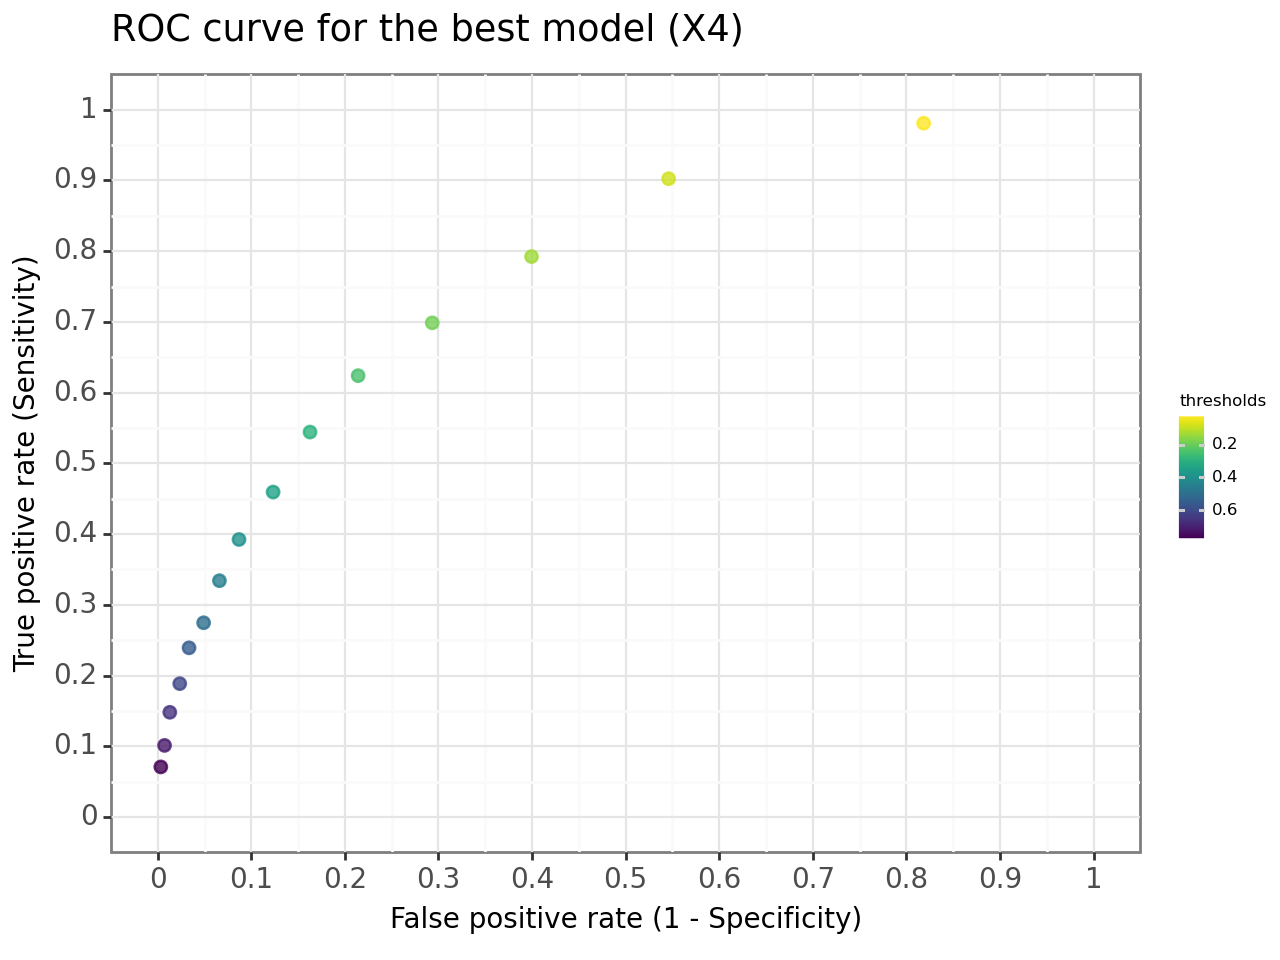

<Figure Size: (640 x 480)>

In [82]:
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(
            x = "False positive rate (1 - Specificity)", 
            y = "True positive rate (Sensitivity)",
            title = 'ROC curve for the best model (X4)'
        )\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=10),
            axis_title=element_text(size=10),
            legend_text = element_text(size = 6),
            legend_title = element_text(size = 6),
            legend_key_size=6)

In [83]:
%matplotlib inline

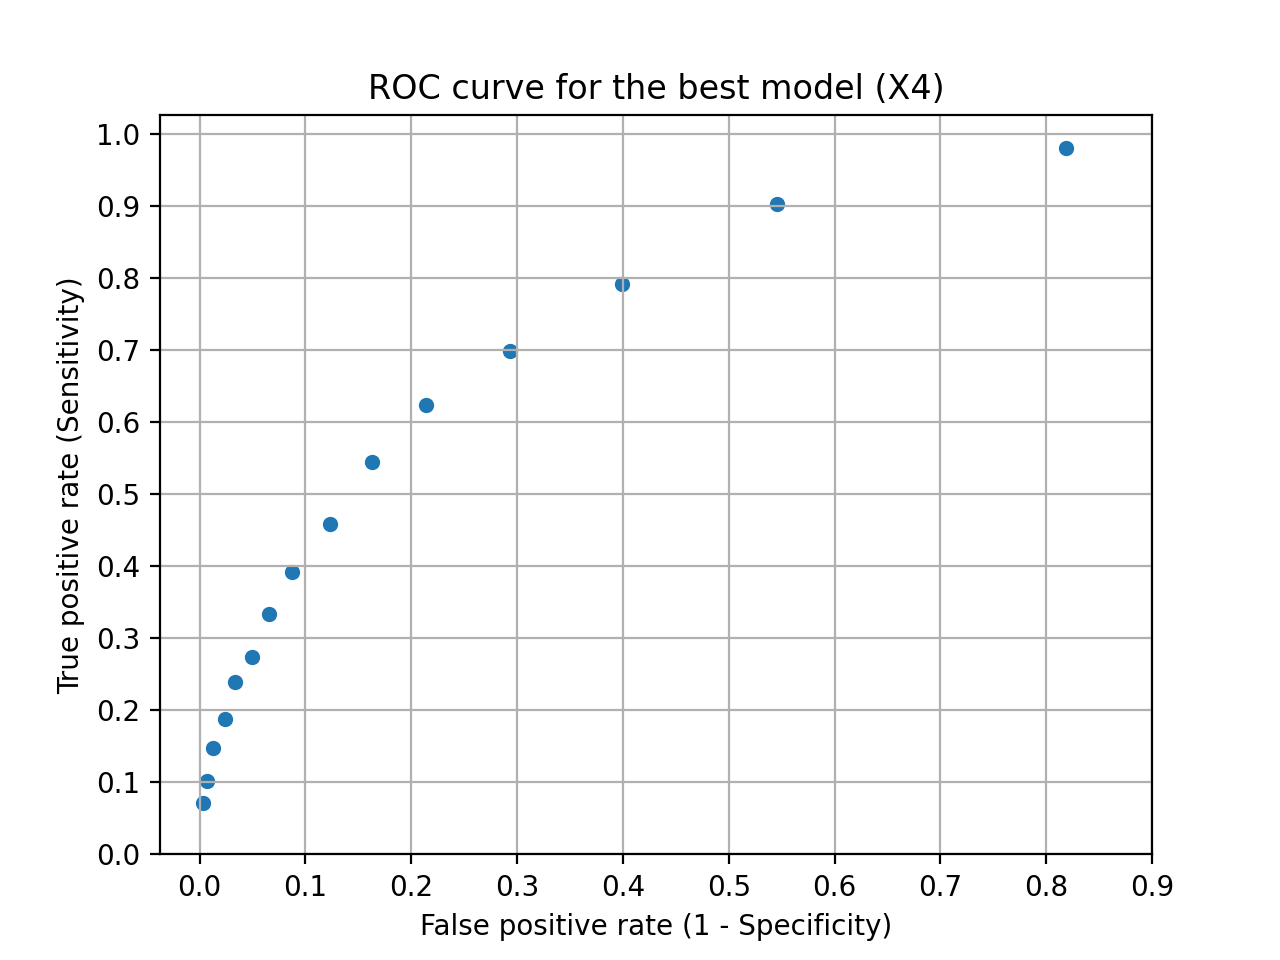

In [84]:
ax = sns.scatterplot(
    data = tpr_fpr_for_thresholds,
    x = 'false_positive_rates', 
    y = 'true_positive_rates', 
    marker = 'o')
ax.set_title('ROC curve for the best model (X4)')
ax.set_xlabel("False positive rate (1 - Specificity)"), 
ax.set_ylabel("True positive rate (Sensitivity)")
ax.set_xticks([x/10 for x in range(0,10,1)])
ax.set_yticks([x/10 for x in range(0,11,1)])
ax.grid(True);

**continuous ROC on holdout with best model (Logit 4)**

*ggplot*

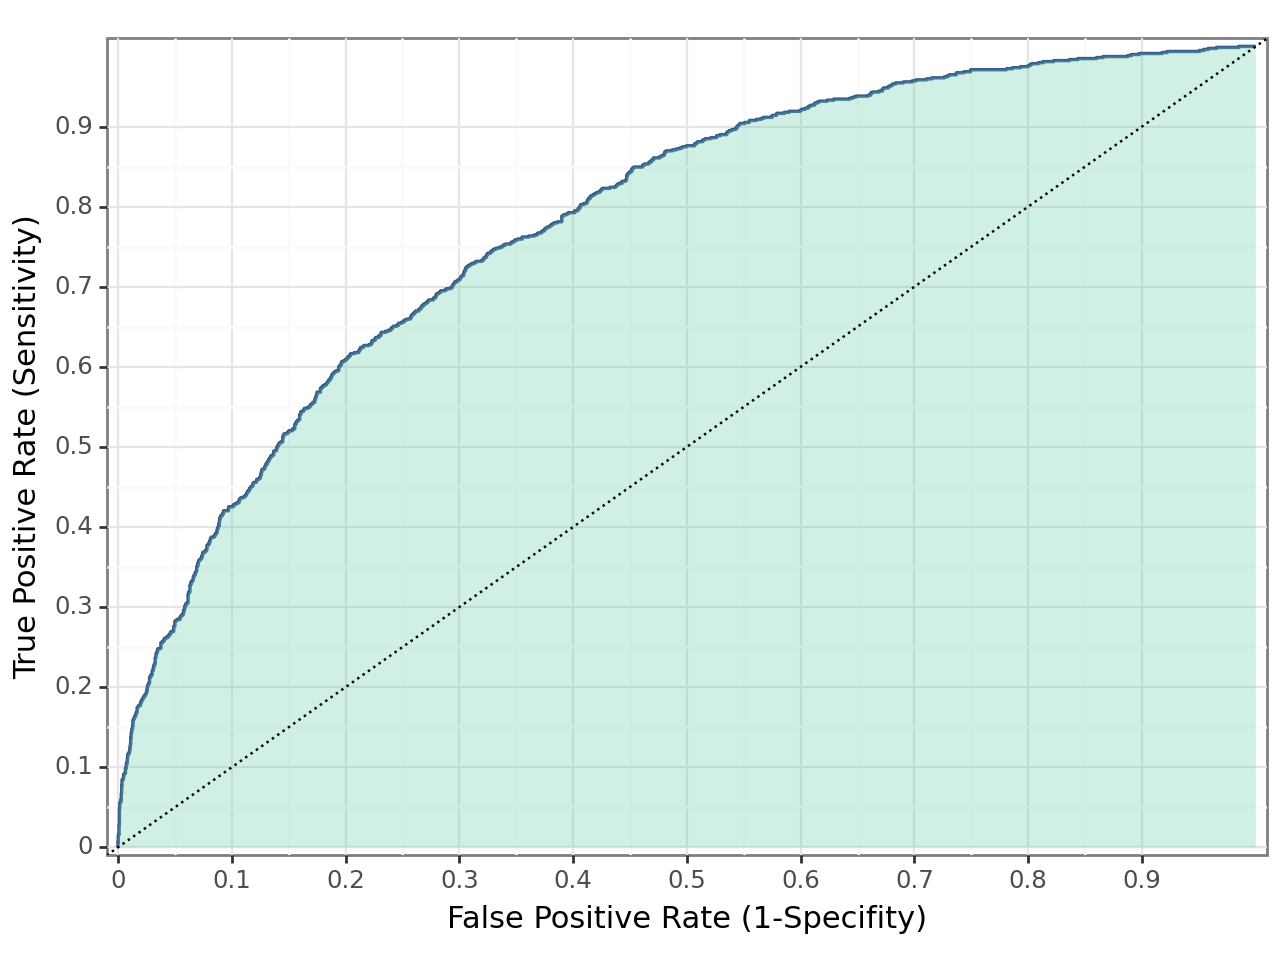

<Figure Size: (640 x 480)>

In [85]:
create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

*seaborn*

In [86]:
fpr, tpr, thresholds = roc_curve(y_holdout, logit_predicted_probabilities_holdout)

In [87]:
df_ = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds
})

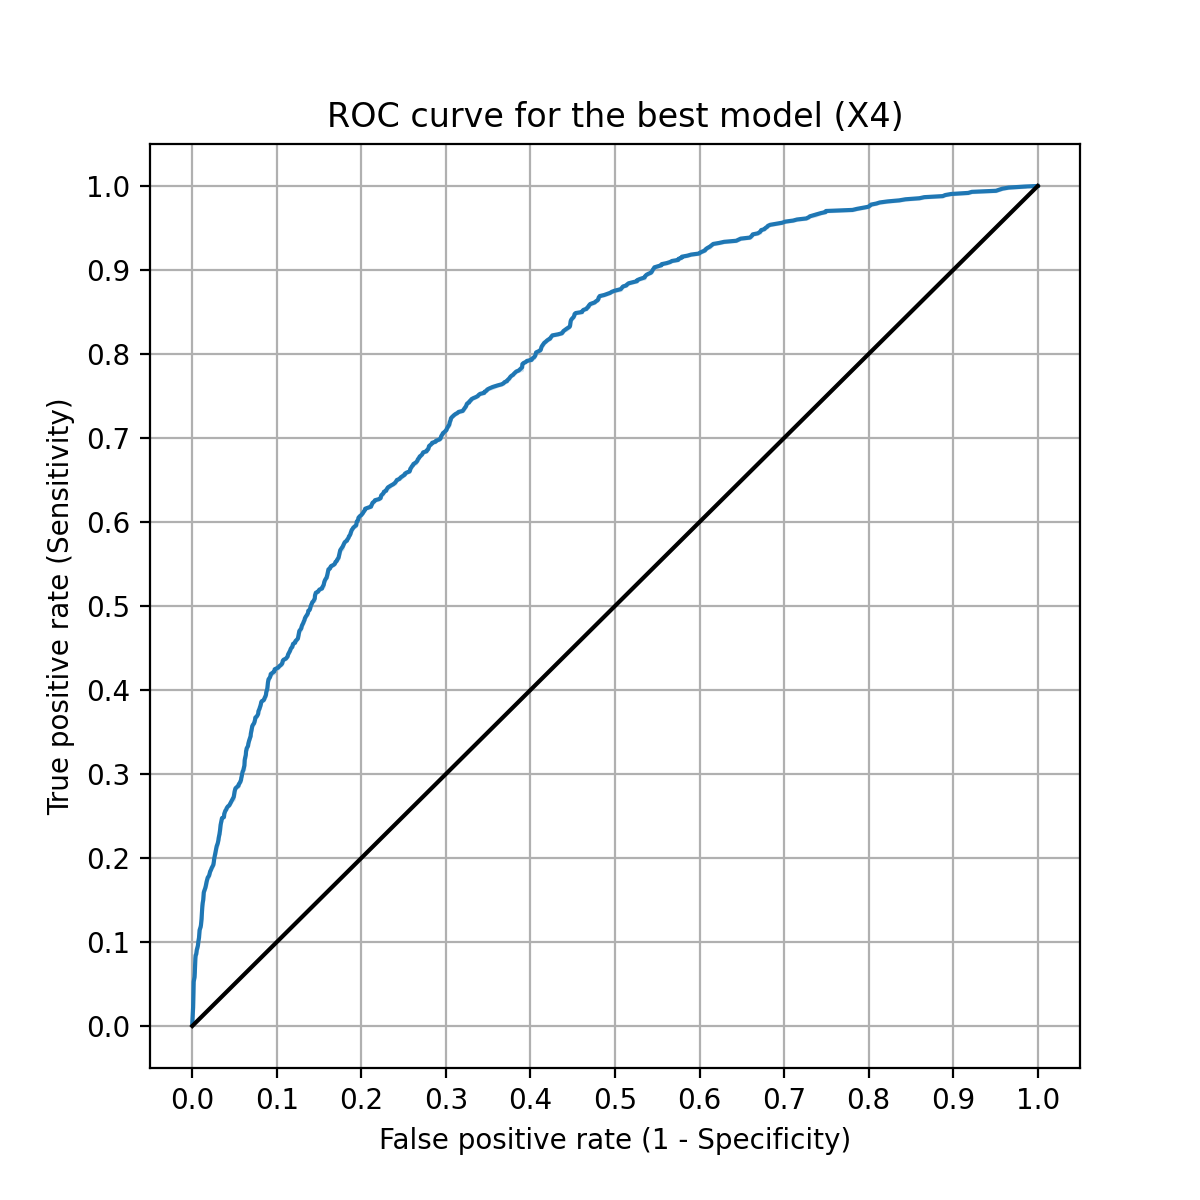

In [88]:
plt.figure(figsize = (6,6))
ax = sns.lineplot(
    data = df_,
    x = fpr, 
    y = tpr)
ax.set_title('ROC curve for the best model (X4)')
ax.set_xlabel("False positive rate (1 - Specificity)"), 
ax.set_ylabel("True positive rate (Sensitivity)")
ax.set_xticks([x/10 for x in range(0,11,1)])
ax.set_yticks([x/10 for x in range(0,11,1)])
ax.plot(df_.fpr, df_.fpr, color = 'k')
ax.grid(True);

**Confusion table with different tresholds**

default: the threshold 0.5 is used to convert probabilities to binary classes

In [89]:
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no default): ',counts[0])
print(values[1],' (default): ',counts[1])

0  (no default):  3442
1  (default):  365


confusion matrix: summarize different type of errors and successfully predicted cases   
positive = "yes": explicitly specify the positive case

In [90]:
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actual no default', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1

,Predicted no default,Predicted default
Actual no default,2869,148
Actual default,573,217


Applying different thresholds

- 0.5 same as before

In [91]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < 0.5, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actual no default', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1b

,Predicted no default,Predicted default
Actual no default,2869,148
Actual default,573,217


In [92]:
print(f'FPR: {round(cm1b.iloc[0,1] / cm1b.iloc[0].sum(), 3)}')

FPR: 0.049


- a sensible choice: mean of predicted probabilities

In [93]:
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_default_prob, 3)

0.209

In [94]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm2

,Predicted no default,Predicted default
Actul no defaul,2175,842
Actual default,248,542


In [95]:
print(f'FPR: {round(cm2.iloc[0,1] / cm2.iloc[0].sum(), 3)}')

FPR: 0.279


#### Calibration curve

How well do estimated vs actual event probabilities relate to each other?

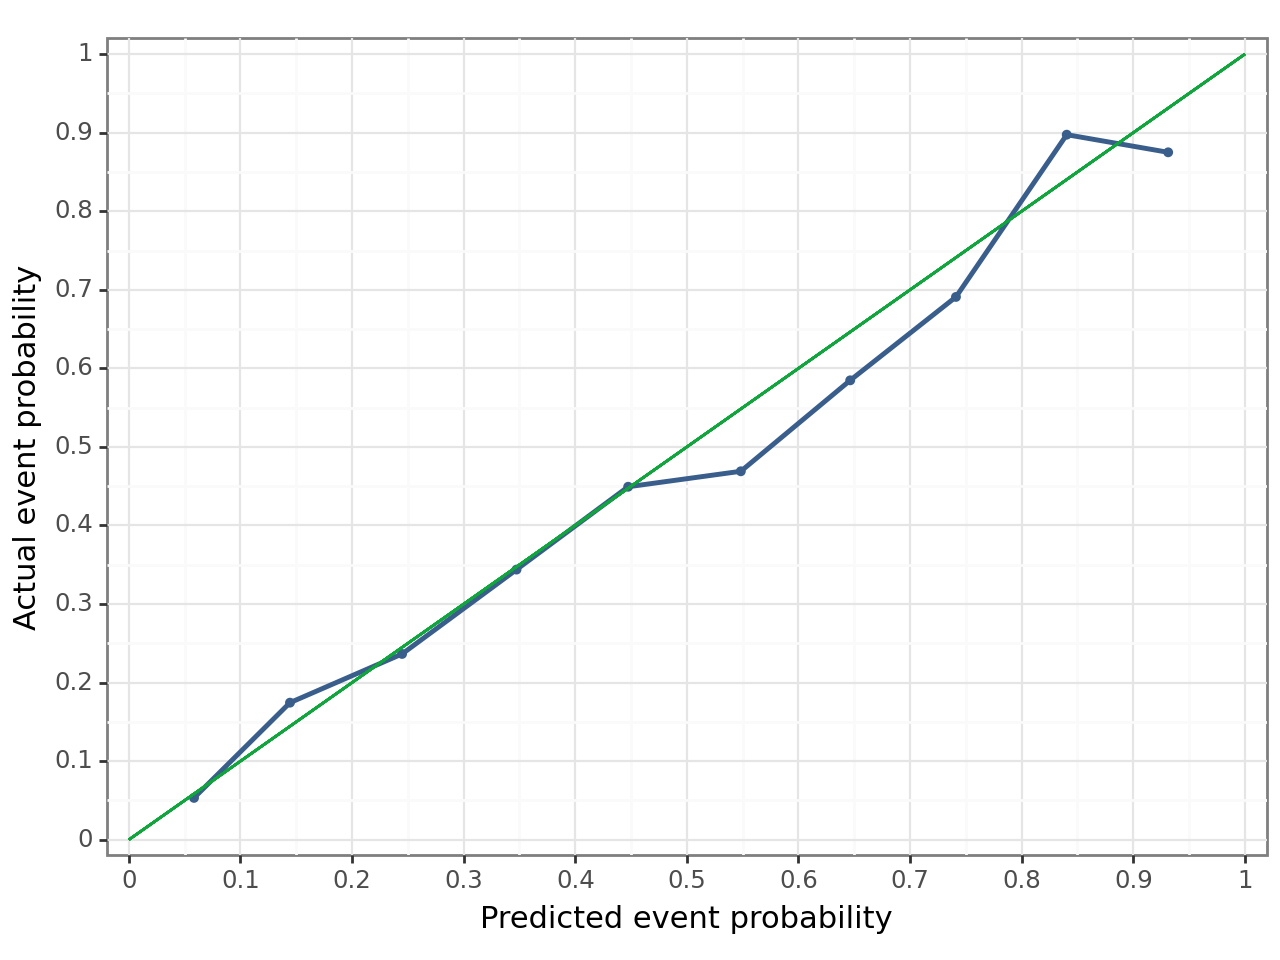

<Figure Size: (640 x 480)>

In [96]:
holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(
    holdout, 
    # file_name = "ch17-figure-1-logit-m4-calibration",
    prob_var='best_logit_no_loss_pred', 
    actual_var='default',
    y_lab="Actual event probability", 
    n_bins=10, 
    breaks=None)

### AUC using a loss function

**Loss function**: relative cost of of a false negative classification (as compared with a false positive classification)

In [97]:
FP = 1
FN = 10
cost = FN/FP

# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)
prevelance

0.2008011031584477

**Draw ROC Curve and find optimal threshold with loss function**

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

In [98]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [99]:
fold5_all_coords['X1']

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,581.0,2464.0,581,2464,3045,inf
1,1.0,0.0,581.0,2463.0,581,2464,3045,0.768473
2,3.0,0.0,581.0,2461.0,581,2464,3045,0.762485
3,3.0,2.0,579.0,2461.0,581,2464,3045,0.758223
4,4.0,3.0,578.0,2460.0,581,2464,3045,0.753533
...,...,...,...,...,...,...,...,...
791,2365.0,579.0,2.0,99.0,581,2464,3045,0.036436
792,2365.0,580.0,1.0,99.0,581,2464,3045,0.036314
793,2382.0,580.0,1.0,82.0,581,2464,3045,0.034656
794,2382.0,581.0,0.0,82.0,581,2464,3045,0.034625


In [100]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()

In [101]:
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,0.086150,0.105174,0.727031,0.686043
1,X2,0.096904,0.096607,0.657428,0.635140
2,X3,0.090639,0.097381,0.630835,0.619704
3,X4,0.091476,0.093846,0.620197,0.604269
4,X5,0.091982,0.109790,0.625450,0.605911
5,LASSO,0.079319,0.071255,0.631756,0.639080


### Loss plot based on Fold5 in CV

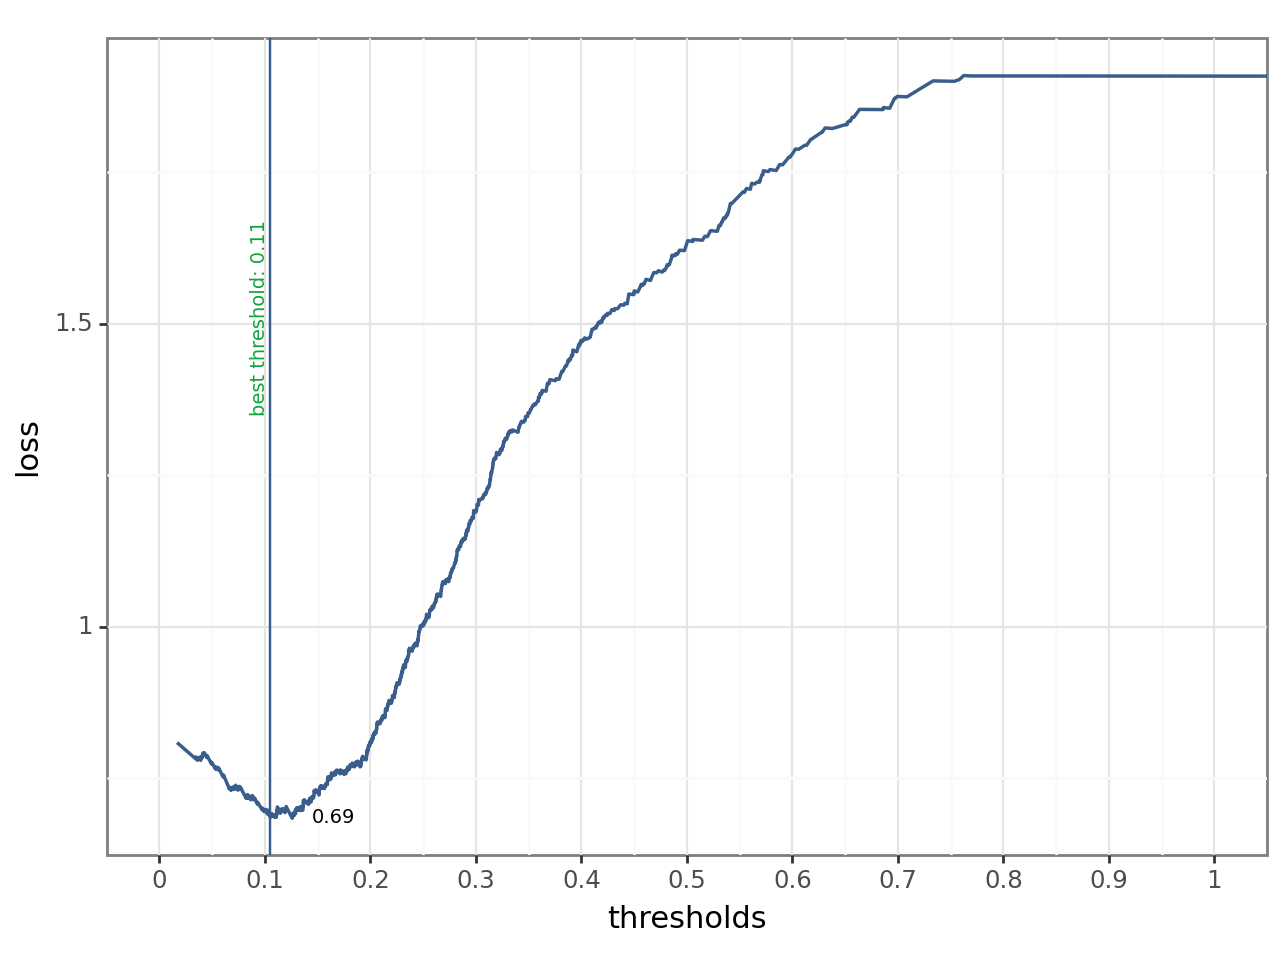

<Figure Size: (640 x 480)>

In [102]:
model_to_plot = 'X1'
create_loss_plot(
    fold5_all_coords[model_to_plot], 
    fold5_threshold[model_to_plot], 
    fold5_expected_loss[model_to_plot])

#### ROC plot plot based on Fold5 in CV

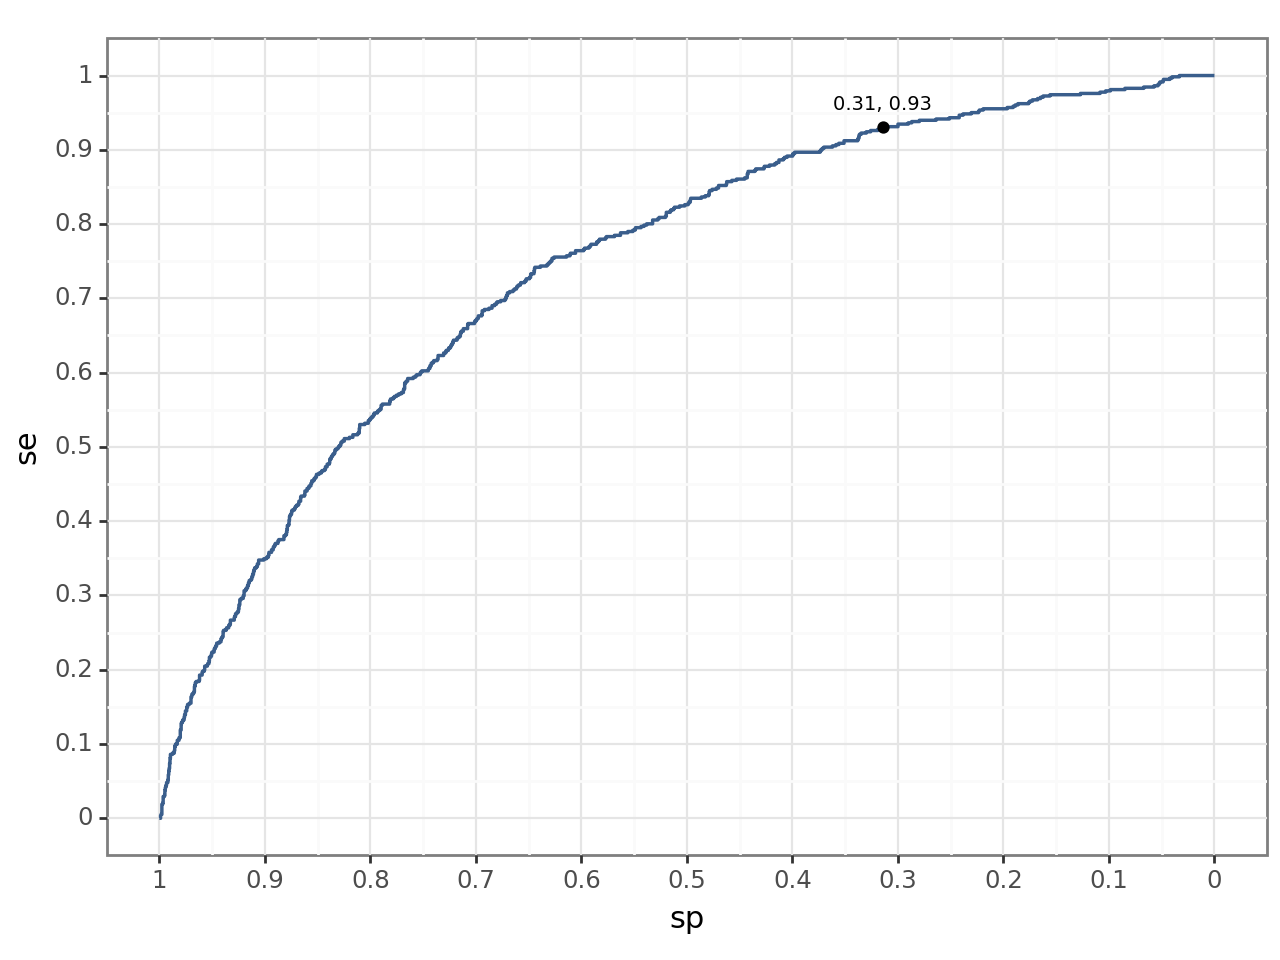

<Figure Size: (640 x 480)>

In [103]:
model_to_plot = 'X1'
create_roc_plot_with_optimal(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot])

#### Pick best model based on average expected loss

### X4

In [104]:
best_logit_optimal_treshold = best_thresholds_cv["X4"]
best_logit_optimal_treshold

0.09147605628091887

**Get expected loss on holdout**

In [105]:
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.635

In [106]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm3

,Predicted no default,Predicted default
Actul no defaul,1260,1757
Actual default,66,724


In [107]:
print(f'FPR: {round(cm3.iloc[0,1] / cm3.iloc[0].sum(), 3)}')

FPR: 0.582


### Prediction with random forest 

In [108]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

In [109]:
rfvars_train.columns

Index(['sales_mil', 'd1_sales_mil_log', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
       'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
       'material_exp', 'personnel_exp', 'profit_loss_year', 'sales',
       'share_eq', 'subscribed_cap', 'female', 'ceo_age', 'flag_high_ceo_age',
       'flag_low_ceo_age', 'flag_miss_ceo_age', 'ceo_count', 'labor_avg_mod',
       'flag_miss_labor_avg', 'foreign_management', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'age', 'age2', 'new',
       'C(ind2_cat)[27]', 'C(ind2_cat)[28]', 'C(ind2_cat)[29]',
       'C(ind2_cat)[30]', 'C(ind2_cat)[33]', 'C(ind2_cat)[55]',
       'C(ind2_cat)[56]', 'C(m_region_loc)[East]', 'C(m_region_loc)[West]',
       'C(urban_m)[2]', 'C(urban_m)[3]'],
      dtype='object')

#### Graph example

In [110]:
%%time 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = rfvars_train[['sales_mil','profit_loss_year','foreign_management']]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, 
    min_samples_leaf=100, 
    max_depth=3, 
    random_state=41).fit(
    data_for_graph, 
    y_train)

plt.figure()
plt.figure(figsize=(11,11))
plot_tree(rf_for_graph, 
          feature_names = data_for_graph.columns, 
          filled=True, 
          rounded=True, 
          proportion=True, 
          fontsize = 10)
plt.title("Decision trees")
plt.show() 

InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['sales_mil', 'profit_loss_year', 'foreign_management'], dtype='object') instead.

<Figure size 640x480 with 0 Axes>

<Figure size 1100x1100 with 0 Axes>

### Probability forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the `max_samples` parameter if `bootstrap = True` (default), otherwise the whole dataset is used to build each tree.
- `max_features`: number of features to consider when looking for the best split
- `min_samples_fit`: the minimum number of samples required`to split an internal node

In [111]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [112]:
prob_forest = RandomForestClassifier(
    random_state=20240205, 
    n_estimators=500, 
    oob_score=True)

prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv=k, 
    refit='accuracy',
    scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1)

In [113]:
%%time
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

CPU times: total: 28.4 s
Wall time: 2min 49s


**CV summary table**

In [114]:
prob_forest_fit.cv_results_

{'mean_fit_time': array([34.03872371, 33.05734735, 43.25325046, 45.11622119, 51.0541707 ,
        40.22153616]),
 'std_fit_time': array([0.59790834, 0.90493192, 2.56052267, 1.33464284, 4.67441046,
        0.32161328]),
 'mean_score_time': array([1.40835919, 1.59686294, 1.29390144, 1.21894374, 0.83159046,
        0.71590428]),
 'std_score_time': array([0.09714539, 0.19058137, 0.11917492, 0.09184801, 0.10716878,
        0.08520633]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[5, 5, 6, 6, 7, 7],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[11, 16, 11, 16, 11, 16],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object)

Our grid has 3x2=6 elements. 

In [115]:
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5
cv_accuracy

array([0.82592472, 0.8259904 , 0.82559634, 0.82546517, 0.826253  ,
       0.82605608])

In [116]:
prob_forest_fit.best_score_

0.8262529986296598

In [117]:
cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5
cv_auc

array([0.80870461, 0.80916281, 0.80831592, 0.80867397, 0.80744901,
       0.807717  ])

In [118]:
cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5
cv_rmse

array([0.35440906, 0.35436994, 0.35433435, 0.35432007, 0.35445166,
       0.35448977])

In [119]:
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [120]:
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.825925,0.808705,0.354409
1,5,16,0.825990,0.809163,0.354370
2,6,11,0.825596,0.808316,0.354334
3,6,16,0.825465,0.808674,0.354320
4,7,11,0.826253,0.807449,0.354452
5,7,16,0.826056,0.807717,0.354490


**Optimal parameter values**

In [121]:
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 11}

**Average RMSE and AUC over folds**

In [122]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_max_features) & 
    (prob_forest_cv_results.min_samples_split == best_min_sample_split)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

In [123]:
CV_RMSE

{'X1': 0.3742391033575232,
 'X2': 0.36585130623556505,
 'X3': 0.3645554228687324,
 'X4': 0.36212347041537873,
 'X5': 0.3618610290460555,
 'LASSO': 0.36182039908528774,
 'rf_p': 0.35445166342752776}

In [124]:
CV_AUC

{'X1': 0.7363385989228117,
 'X2': 0.7701587659933226,
 'X3': 0.7781583085165772,
 'X4': 0.7843999329962529,
 'X5': 0.7842228170361241,
 'LASSO': 0.7847717937550562,
 'rf_p': 0.8074490128243369}

**Get fold level RMSE and AUC**

In [125]:
CV_RMSE_folds_rf_p = list()

for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)

CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()

for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)

CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p

In [126]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5,LASSO,rf_p
0,0.743138,0.772483,0.783986,0.789541,0.789331,0.792315,0.816436
1,0.740873,0.768960,0.778472,0.785627,0.782292,0.783751,0.802342
2,0.727144,0.770054,0.776256,0.783436,0.782897,0.780713,0.806037
3,0.724029,0.763393,0.770604,0.777043,0.777172,0.776327,0.795925
4,0.746510,0.775903,0.781473,0.786353,0.789423,0.790753,0.816505


**Now use loss function and search for best thresholds and expected loss over folds**

In [127]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(
        random_state=20240205, 
        n_estimators=500, 
        oob_score=True,
        criterion = 'gini', 
        max_features = best_max_features, min_samples_split = best_min_sample_split)
    
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)

In [128]:
best_thresholds

[0.12098499785238918,
 0.1118404514560088,
 0.13082139117332617,
 0.09724077507459863,
 0.11804990817575961]

In [129]:
expected_loss

[0.5768220617202889,
 0.608338804990151,
 0.5968483256730138,
 0.5853578463558765,
 0.5717569786535304]

In [130]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_rf

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,581.0,2464.0,581,2464,3045,inf
1,0.0,1.0,580.0,2464.0,581,2464,3045,0.893149
2,0.0,13.0,568.0,2464.0,581,2464,3045,0.793049
3,3.0,13.0,568.0,2461.0,581,2464,3045,0.787252
4,3.0,24.0,557.0,2461.0,581,2464,3045,0.746264
...,...,...,...,...,...,...,...,...
706,2243.0,580.0,1.0,221.0,581,2464,3045,0.014782
707,2440.0,580.0,1.0,24.0,581,2464,3045,0.002622
708,2440.0,581.0,0.0,24.0,581,2464,3045,0.002436
709,2462.0,581.0,0.0,2.0,581,2464,3045,0.000118


In [131]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [132]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [133]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.354,0.807,0.116,0.118,0.588,0.572


**Plots based on Fold5 in CV**

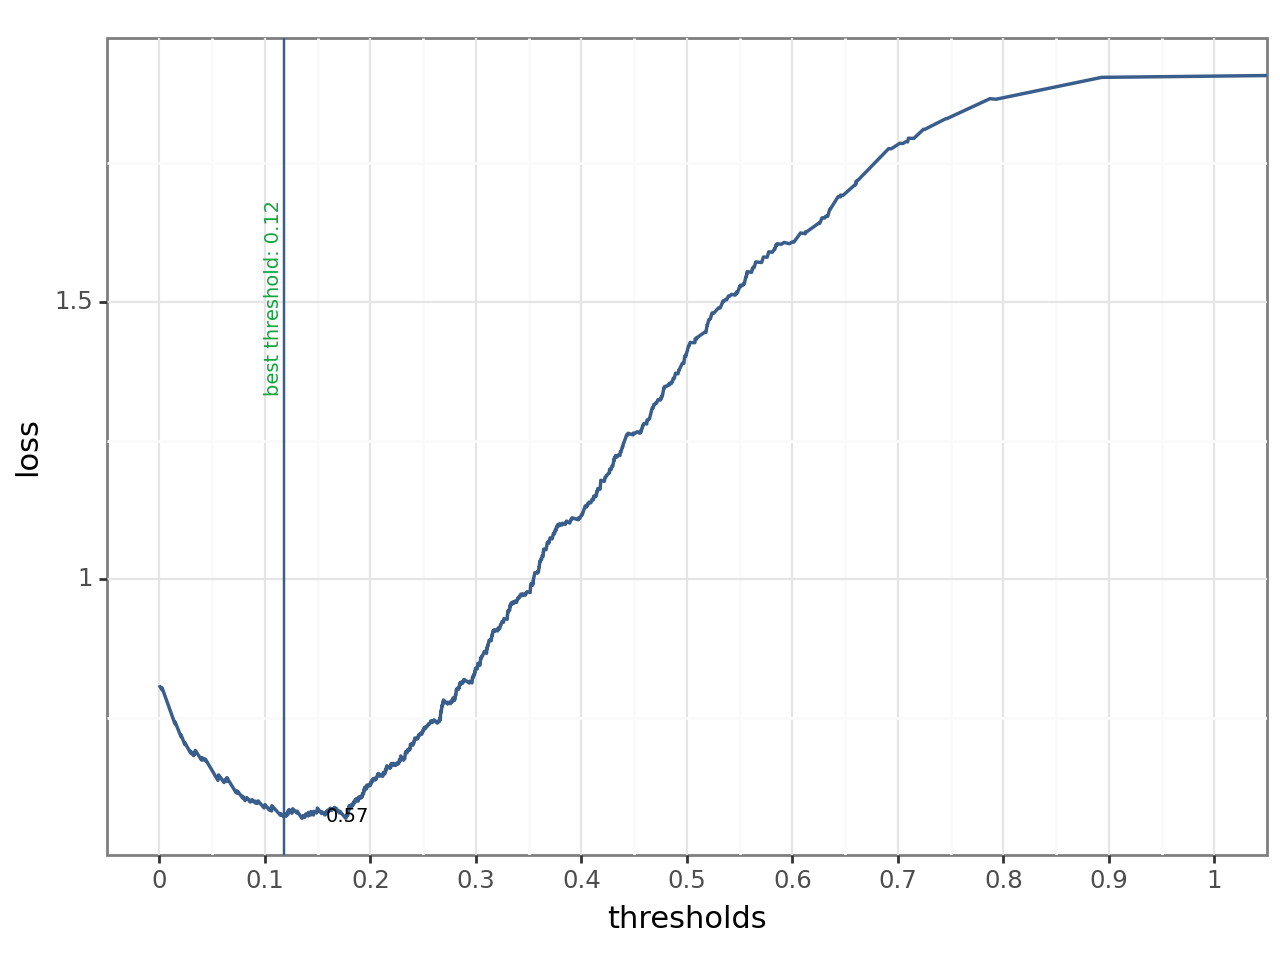

<Figure Size: (640 x 480)>

In [134]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

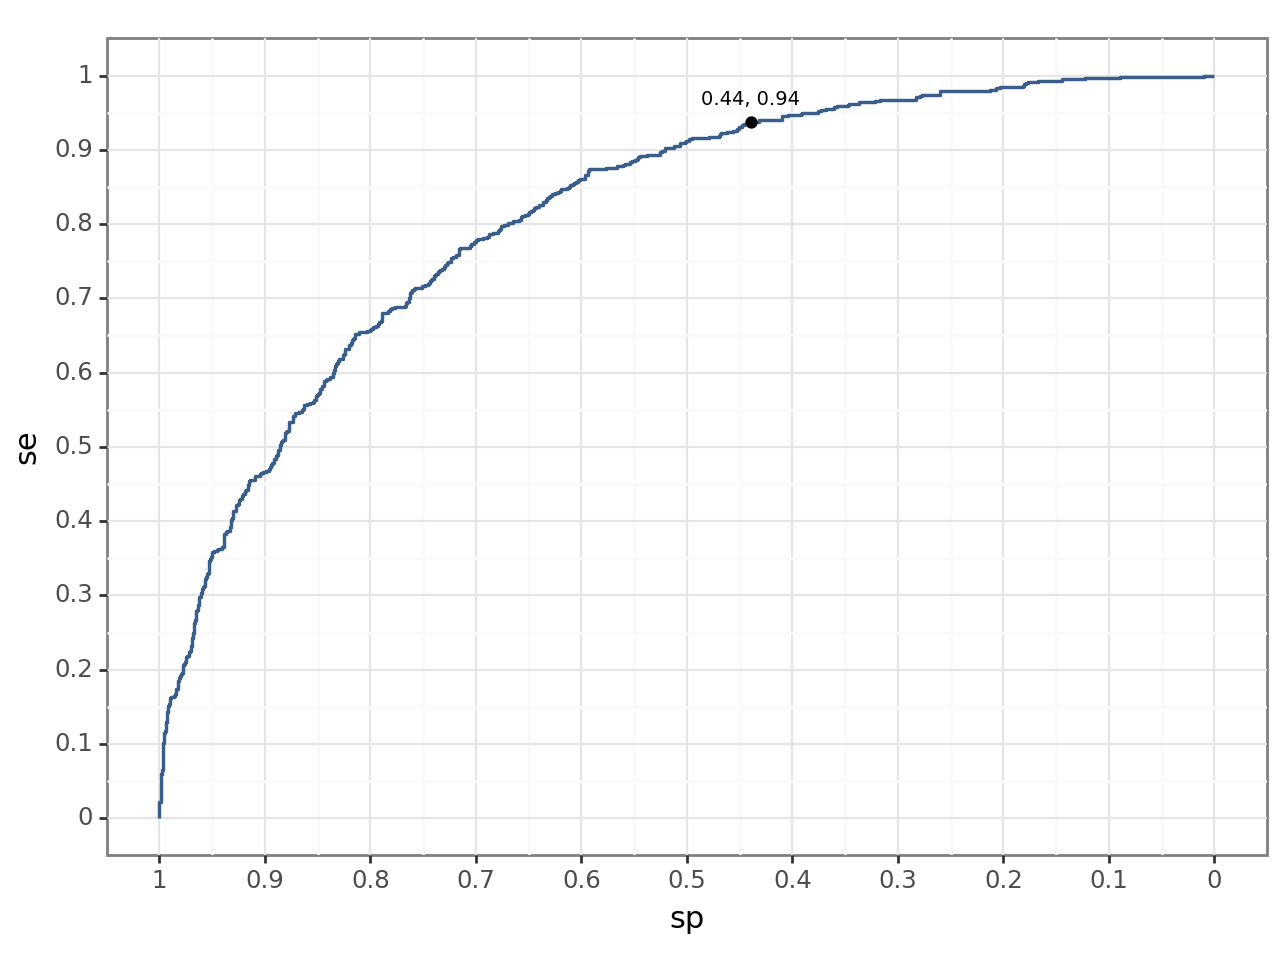

<Figure Size: (640 x 480)>

In [135]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

**Take model to holdout and estimate RMSE, AUC and expected loss**

In [136]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.357

**ROC AUC  on holdout**

In [137]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.806

**Expected loss on holdout**

In [138]:
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.606

In [139]:
import datetime
print(datetime.datetime.now())

2024-02-05 18:02:51.521806


### Getting probalbilities and classifications from RandomforestClassifier

- classes

In [140]:
prob_forest_best_fold.predict(rfvars_holdout)

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

- probabilities

In [141]:
prob_forest_best_fold.predict_proba(rfvars_holdout)

array([[0.99179767, 0.00820233],
       [0.48560229, 0.51439771],
       [0.52334014, 0.47665986],
       ...,
       [0.86457666, 0.13542334],
       [0.88701345, 0.11298655],
       [0.92888154, 0.07111846]])

## Final results

In [142]:
nvars['rf_p'] = len(rfvars.columns)

In [143]:
summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

In [144]:
summary_results

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,11,0.374239,0.736339,0.086150,0.727031
1,X2,18,0.365851,0.770159,0.096904,0.657428
2,X3,35,0.364555,0.778158,0.090639,0.630835
3,X4,79,0.362123,0.784400,0.091476,0.620197
4,X5,153,0.361861,0.784223,0.091982,0.625450
5,LASSO,134,0.361820,0.784772,0.079319,0.631756
6,rf_p,44,0.354452,0.807449,0.115788,0.587825
